In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [2]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [3]:
# We filter the country, the variable to predict and the dates

country = 'Germany'
variable = 'new_cases_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [4]:
# We read the endogenous data (coronavirus data) (for now, from a local file)

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])

In [5]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [6]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(242, 1) (242, 14)


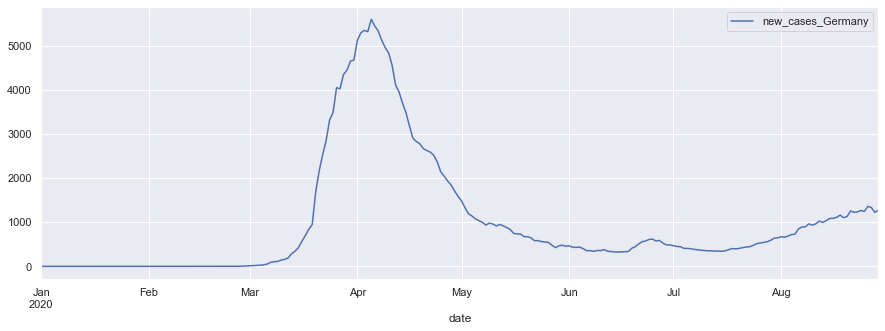

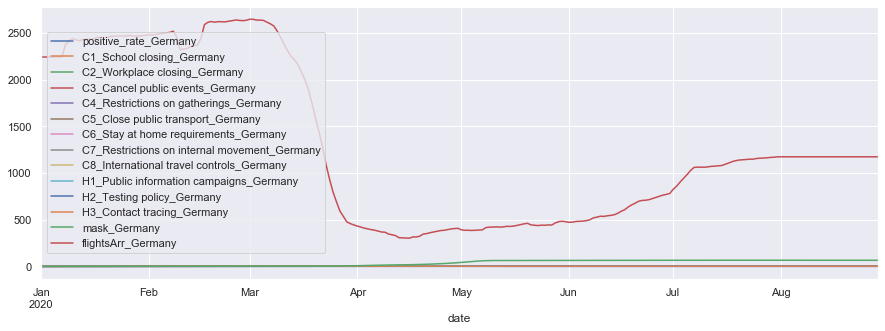

In [7]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [8]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [9]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(242,) (242, 14)


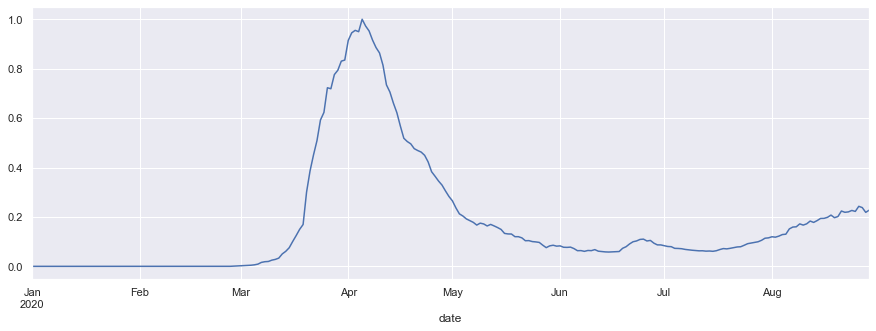

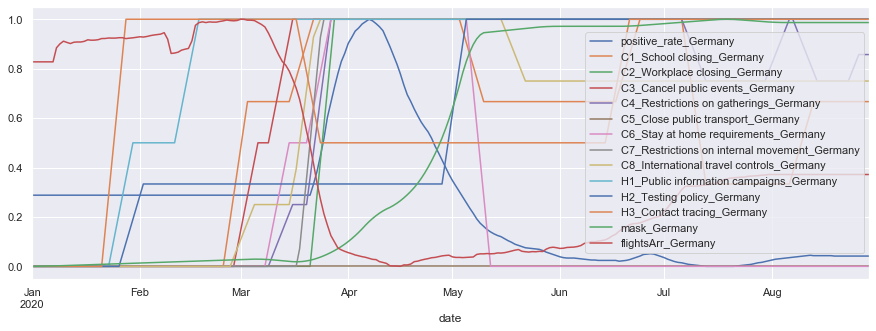

In [10]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [11]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [12]:
train_size, test_size

(205, 37)

# Stationarity: estimate differencing term (d)

In [13]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


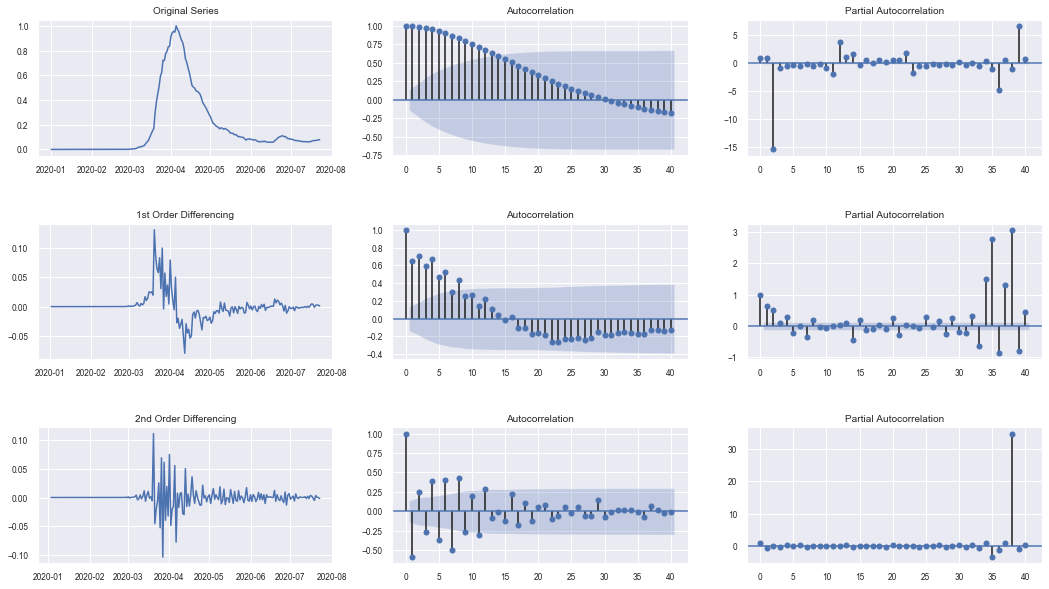

In [14]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

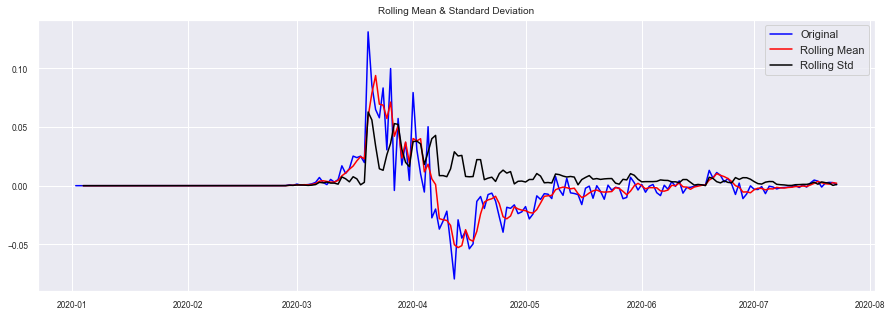

Result of Dicky-Fuller Test


Test Statistic           -3.050238
p-value                   0.030462
#Lags Used               14.000000
#Observations Used      189.000000
Critical Value (1%)      -3.465431
Critical Value (5%)      -2.876957
Critical Value (10%)     -2.574988
dtype: float64

In [15]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [16]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(1, 1, 4)",-1204.479644
1,"(0, 1, 0)",-1181.463419
2,"(1, 2, 4)",-1175.622683
3,"(1, 2, 2)",-1156.711410


# Perform cross-validation on top 2 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [17]:
# Extract top 3 models from previous step (first 3 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])
model3 = ARIMA(order=result_table.iloc[2,0])

In [18]:
best_order = cross_val(y_train, X_train, model1, model2, model3)

Model 1 CV scores: ['0.0908', '0.2271', '0.1037', '0.0202', '0.0210', '0.0204', '0.0755', '0.0150', '0.0519']
Model 2 CV scores: ['0.0952', '0.2170', '0.1074', '0.0381', '0.0298', '0.0206', '0.0716', '0.0099', '0.0528']
Model 3 CV scores: ['0.1008', '0.3495', '0.0531', '0.2106', '0.0131', '0.0063', '0.1772', '0.0401', '0.0530']
Lowest average MAE: 0.06951414293951895 (model1)
Best model order: (1, 1, 4)


                               SARIMAX Results                                
Dep. Variable:      new_cases_Germany   No. Observations:                  205
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 625.287
Date:                Sun, 30 Aug 2020   AIC                          -1210.574
Time:                        18:43:57   BIC                          -1144.211
Sample:                    01-01-2020   HQIC                         -1183.729
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Germany                            0.7929      0.064     12.306      0.000       0.667       0.919
C1_School closing_Germany    

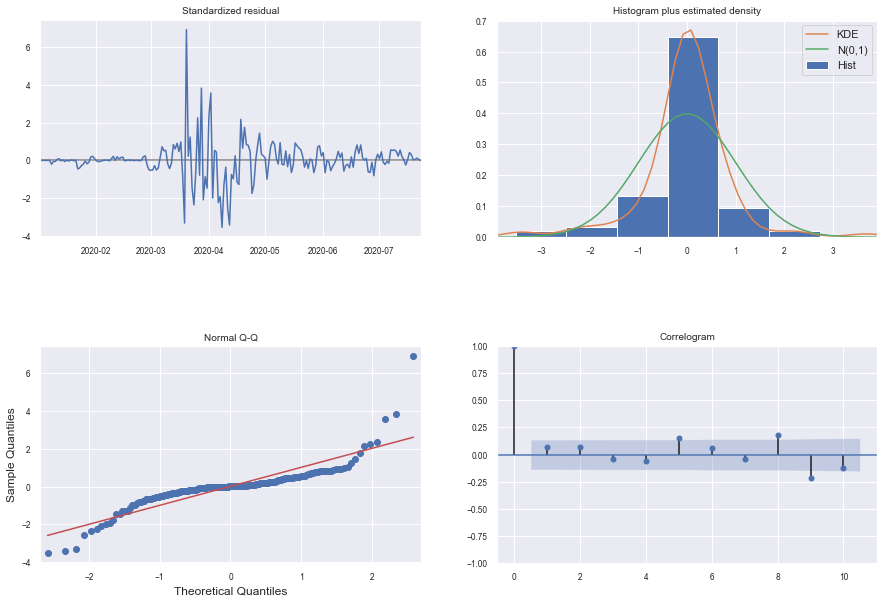

In [19]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [20]:
train_size, test_size, X_test.shape

(205, 37, (37, 14))

Test MAE: 0.055


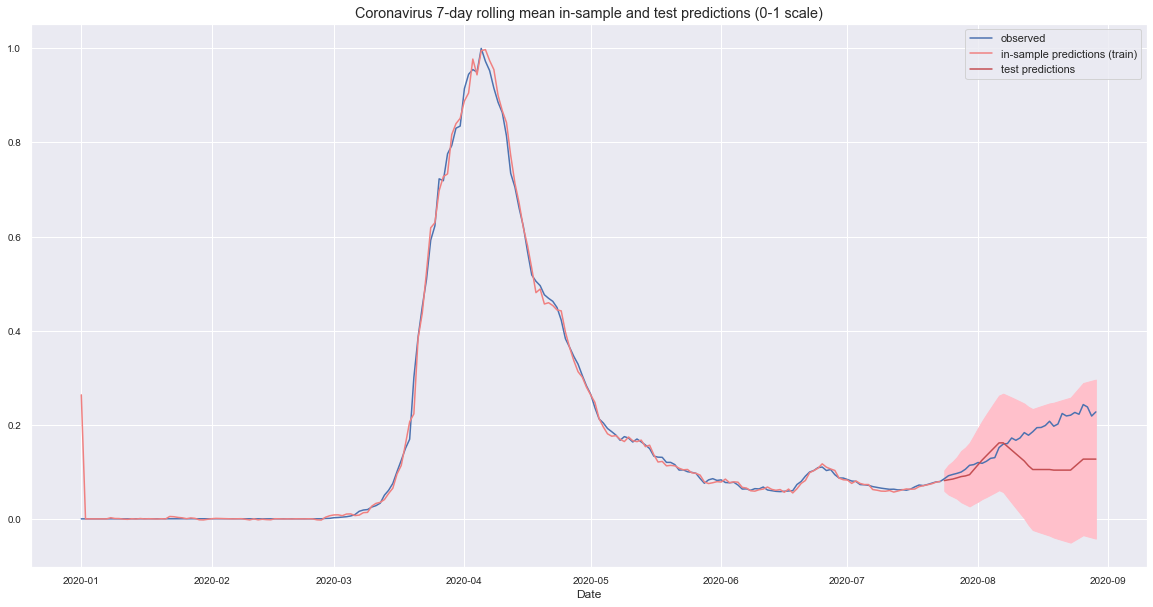

In [21]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [22]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [23]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])

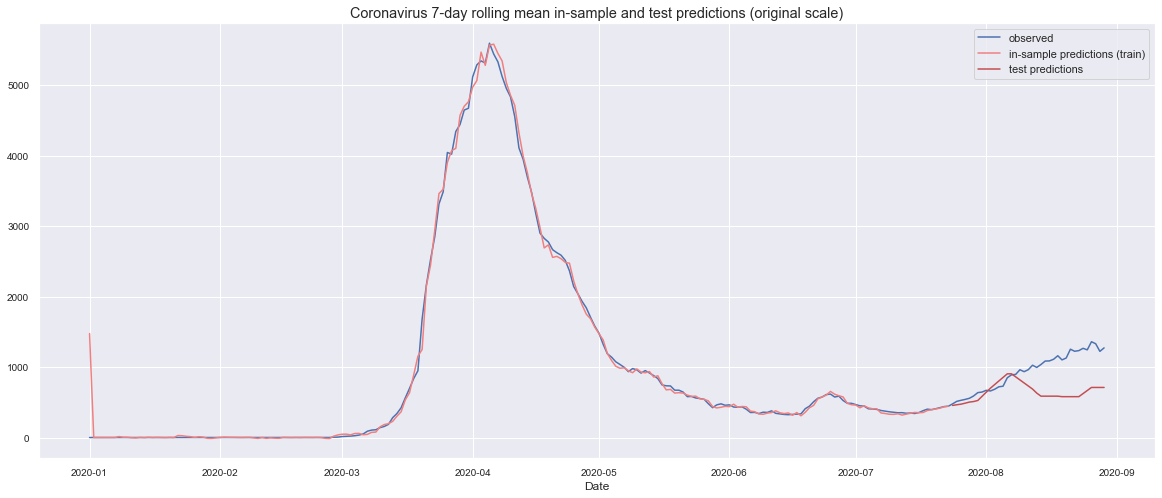

In [24]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [25]:
print("Test MAE (original scale): %.3f" % np.sqrt(mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)))

Test MAE (original scale): 17.488


# Save model so we can then update with future values

In [26]:
# Set model name
filename = './models/' + country + 'SARIMAXmodel.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/GermanySARIMAXmodel.pkl']

In [27]:
# Load the model back in
loaded_model = joblib.load(filename)

In [28]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      new_cases_Germany   No. Observations:                  205
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 625.287
Date:                Sun, 30 Aug 2020   AIC                          -1210.574
Time:                        18:43:59   BIC                          -1144.211
Sample:                    01-01-2020   HQIC                         -1183.729
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Germany                            0.7929      0.064     12.306      0.000       0.667       0.919
C1_School closing_Germany                       -0.0252      0.072     -0.349      0.727      -0.167       0.116
C2_Workplace closing_Germany                    -0.2431      0.050     -4.903      0.000      -0.340      -0.146
C3_Cancel public events_Germany                  0.0313      0.095      0.329      0.742      -0.155       0.218
C4_Restrictions on gatherings_Germany            0.2182      0.071      3.088      0.002       0.080       0.357
C5_Close public transport_Germany            -1.099e-17   9.67e-17     -0.114      0.910   -2.01e-16    1.79e-16
C6_Stay at home requirements_Germany            -0.0476      0.060     -0.789      0.430      -0.166       0.071
C7_Restrictions on internal movement_Germany     0.2939      0.073      4.034      0.000       0.151       0.437
C8_International travel controls_Germany         0.1654      0.101      1.635      0.102      -0.033       0.364
H1_Public information campaigns_Germany         -0.0297      0.308     -0.096      0.923      -0.634       0.574
H2_Testing policy_Germany                       -0.0011      0.106     -0.011      0.991      -0.208       0.206
H3_Contact tracing_Germany                       0.0331      0.092      0.358      0.721      -0.148       0.214
mask_Germany                                    -0.0793      0.118     -0.673      0.501      -0.310       0.152
flightsArr_Germany                               0.0426      0.150      0.284      0.777      -0.251       0.336
ar.L1                                           -0.7605      0.040    -19.125      0.000      -0.838      -0.683
ma.L1                                            0.7924      0.061     12.965      0.000       0.673       0.912
ma.L2                                           -0.0952      0.061     -1.560      0.119      -0.215       0.024
ma.L3                                            0.0896      0.068      1.317      0.188      -0.044       0.223
ma.L4                                            0.4877      0.054      8.955      0.000       0.381       0.594
sigma2                                           0.0001   7.64e-06     16.351      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       79.99   Jarque-Bera (JB):              1519.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.52   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near

# Update model with test observations, to get it ready for future forecasts

In [29]:
# Update model with test sample and re-fit parameters:
res_updated = results.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:      new_cases_Germany   No. Observations:                  242
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 751.030
Date:                Sun, 30 Aug 2020   AIC                          -1462.060
Time:                        18:44:00   BIC                          -1392.364
Sample:                    01-01-2020   HQIC                         -1433.981
                         - 08-29-2020                                         
Covariance Type:                  opg                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Germany                            0.8297      0.057     14.558      0.000       0.718       0.941
C1_School closing_Germany    

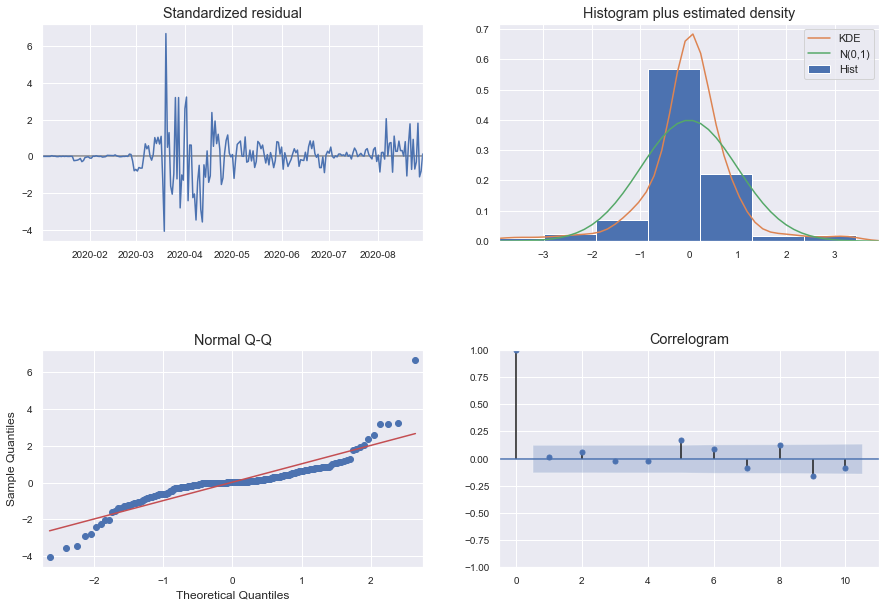

In [30]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

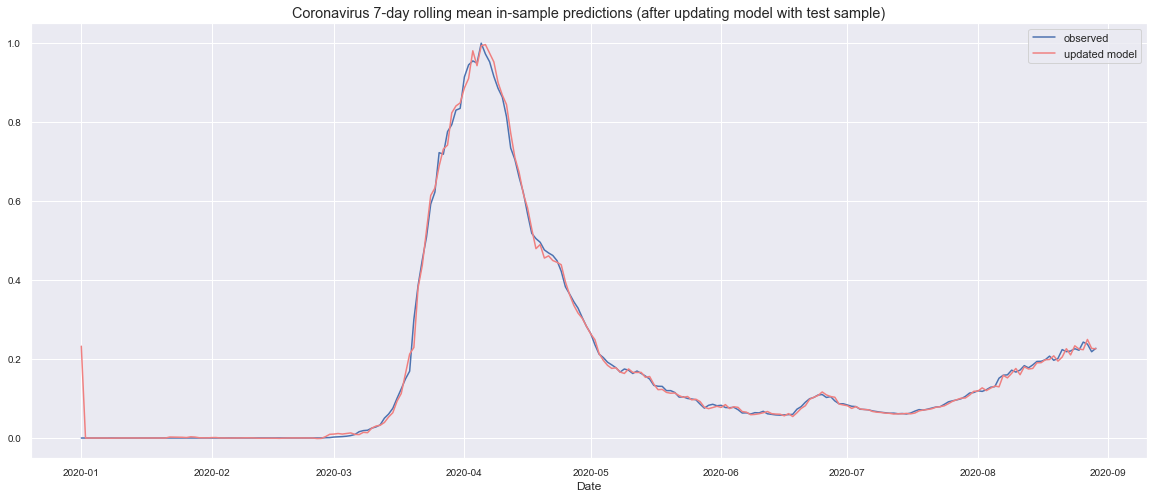

In [31]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [32]:
# Save model again, after updating it with test sample:

joblib.dump(res_updated, filename)

['./models/GermanySARIMAXmodel.pkl']

# Perform forecast

In [33]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdateshift, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

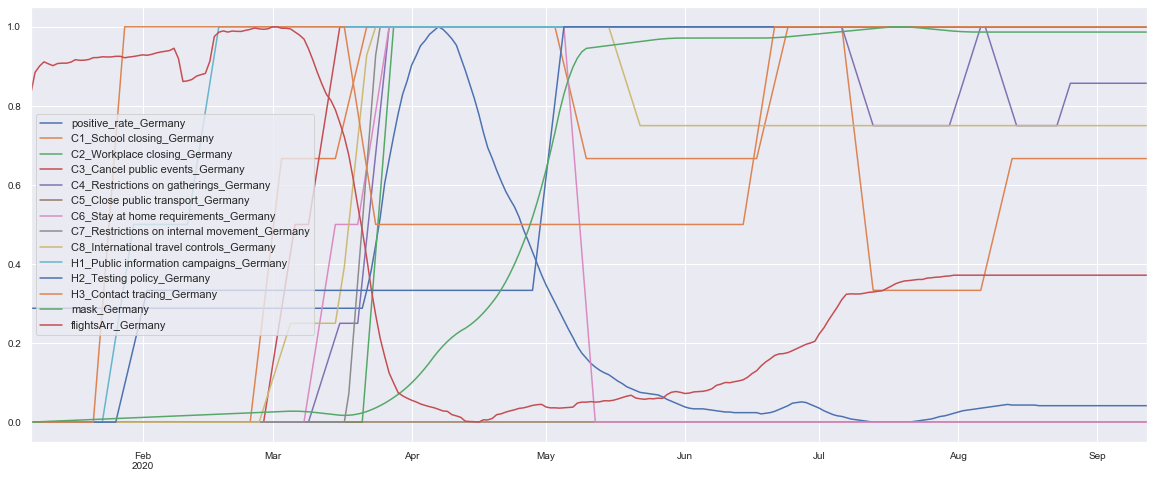

In [34]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.22987651 0.22282013 0.22487636 0.22387721 0.2246477  0.22405353
 0.22451172 0.22415839 0.22443086 0.22422075 0.22438278 0.22425783
 0.22435418 0.22427988]


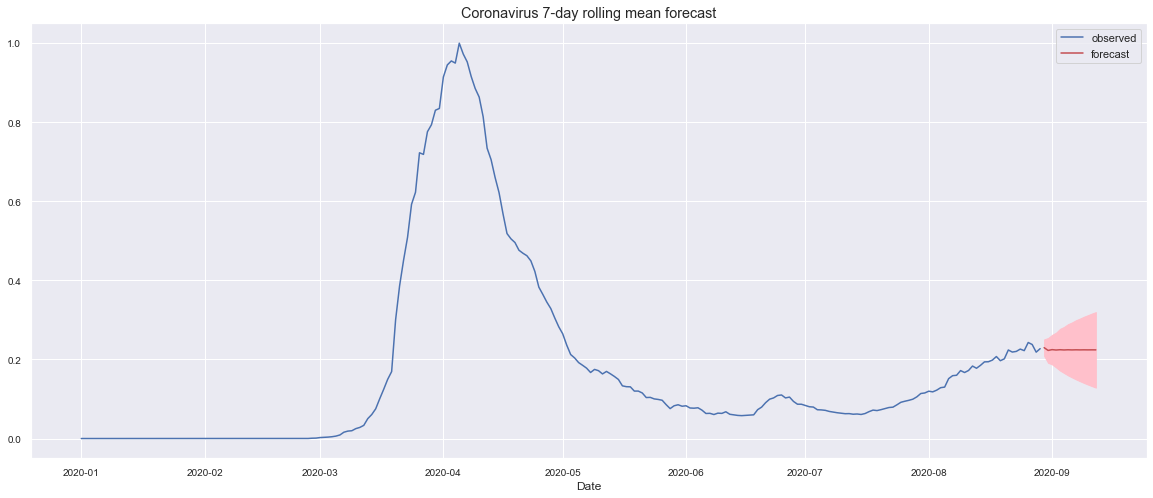

In [35]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [36]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

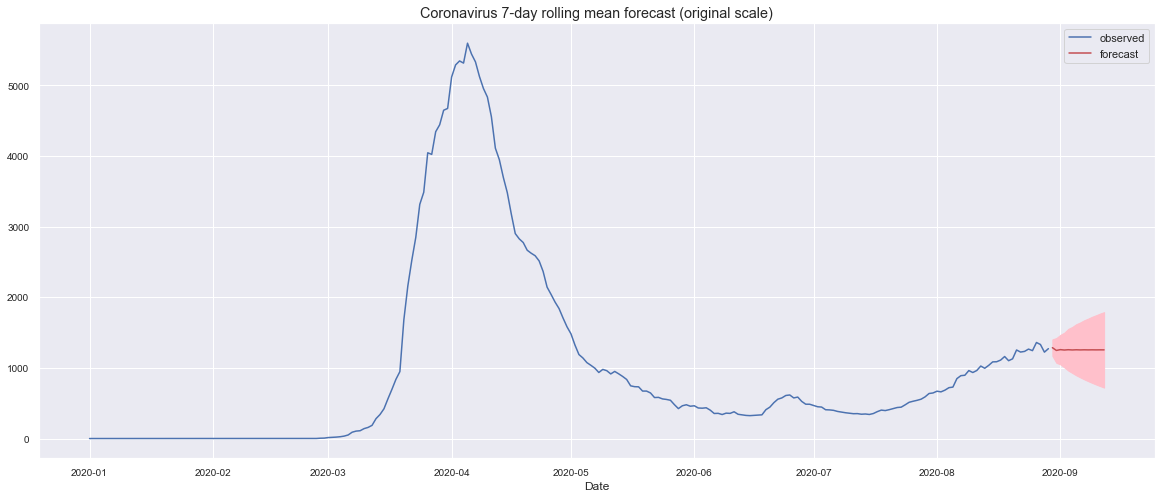

In [37]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.legend()
plt.show()

In [38]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['1286.2', '1246.7', '1258.2', '1252.7', '1257.0', '1253.6', '1256.2', '1254.2', '1255.8', '1254.6', '1255.5', '1254.8', '1255.3', '1254.9']
